<a href="https://colab.research.google.com/github/gorogoro-uk/TensorFlow/blob/master/TF_4_2_TimeSeries_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.2.0
train-test split ok
dataset ok
model definition ok
model fit complete


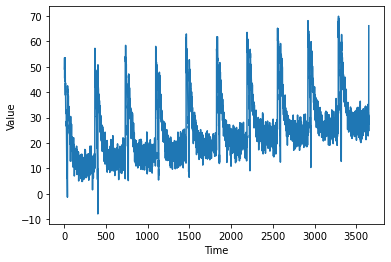

In [1]:

# Sequence Data
# forecast with Dense Neural Net

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

# plot a series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """simple linear trend"""
    return slope * time

def seasonal_pattern(season_time):
    """arbitrary seasonal pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """repeat pattern at regular intervals"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """noise"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# parameters
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create time series & add noise
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=51)

# create train & validation datasets
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# plot data
plot_series(time, series)
print('train-test split ok')

# create windowed data set
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print('dataset ok')

# model definition
# dense (fully connected) neural network
# input shape: [batch_size, input_dim] = [32, 21], unspecified means any batch size allowed
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"),   # 32 x 21 x 100
    tf.keras.layers.Dense(10, activation="relu"),                               # 101 x 10 (100 + bias)
    tf.keras.layers.Dense(1)                                                    # 11 x 1   (10 + bias)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
print('model definition ok')

# fit model
model_history = model.fit(dataset,epochs=100,verbose=0)
print('model fit complete')


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [33]:
# example windowed dataset manipulation
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda j: j.batch(5) )
dataset = dataset.map(lambda j: (j[:-1], j[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
  print(f"x size: {x.shape}")
  print("x= ", x.numpy())
  print(f"y size: {y.shape}") 
  print("y= ", y.numpy())


x size: (2, 4)
x=  [[3 4 5 6]
 [2 3 4 5]]
y size: (2, 1)
y=  [[7]
 [6]]
x size: (2, 4)
x=  [[1 2 3 4]
 [0 1 2 3]]
y size: (2, 1)
y=  [[5]
 [4]]
x size: (2, 4)
x=  [[5 6 7 8]
 [4 5 6 7]]
y size: (2, 1)
y=  [[9]
 [8]]


Text(0, 0.5, 'loss')

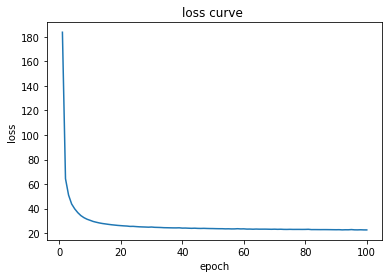

In [4]:
# plot loss per epoch
plt.plot(range(1,101), model_history.history['loss'])
plt.title('loss curve ')
plt.xlabel("epoch")
plt.ylabel("loss")

3.1251967

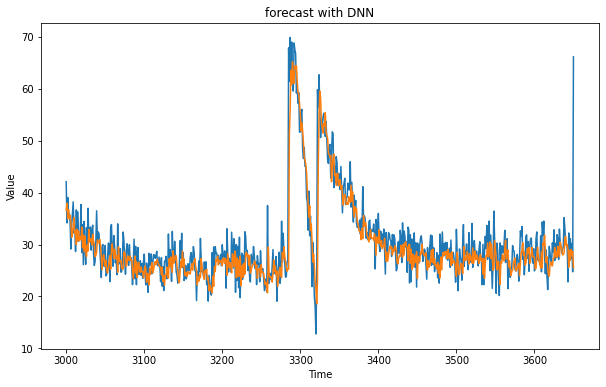

In [3]:
# forecast with model
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# plot forecast
plt.figure(figsize=(10, 6))
plt.title('forecast with DNN')
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# measure error: MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()